# Fitting a straight line to data

https://adrian.pw/blog/fitting-a-line/

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from matplotlib.patches import Ellipse
from scipy.optimize import minimize

rnd = np.random.RandomState(seed=42)

In [2]:
n_data = 16  # number of data points
a_true = 1.255  # randomly chosen truth
b_true = 4.507

# randomly generate some x values over some domain by sampling from a uniform distribution
x = rnd.uniform(0, 2.0, n_data)
x.sort()  # sort the values in place

# evaluate the true model at the given x values
y = a_true * x + b_true

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = rnd.uniform(
    0.1, 0.2, size=n_data
)  # randomly generate uncertainty for each datum
y = rnd.normal(y, y_err)  # re-sample y data with noise

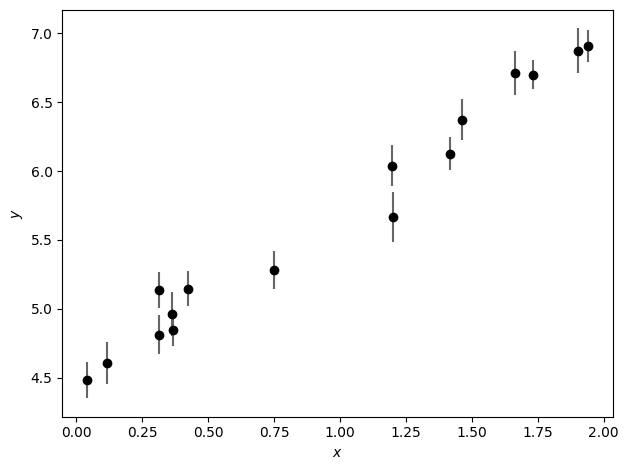

In [3]:
datastyle = dict(linestyle="none", marker="o", color="k", ecolor="#666666")
plt.errorbar(x, y, y_err, **datastyle)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()

In [4]:
def line_model(pars, x):
    """
    Evaluate a straight line model at the input x values.
    """
    return pars[0] * np.array(x) + pars[1]


def weighted_absolute_deviation(pars, x, y, y_err):
    """
    Compute the weighted absolute deviation between the data
    (x, y, y_err) and the model points computed with the input
    parameters (pars).
    """
    chi = (y - line_model(pars, x)) / y_err
    return np.sum(np.abs(chi))


def weighted_squared_deviation(pars, x, y, y_err):
    """
    Compute the weighted squared deviation between the data
    (x, y, y_err) and the model points computed with the input
    parameters (pars).
    """
    chi = (y - line_model(pars, x)) / y_err
    return np.sum(chi**2)

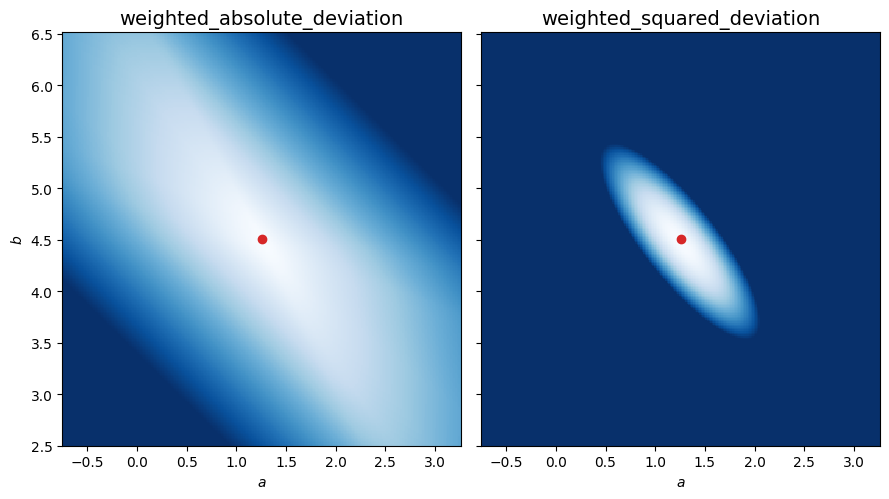

In [5]:
# make a 256x256 grid of parameter values centered on the true values
a_grid = np.linspace(a_true - 2.0, a_true + 2, 256)
b_grid = np.linspace(b_true - 2.0, b_true + 2, 256)
a_grid, b_grid = np.meshgrid(a_grid, b_grid)
ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel())).T

fig, axes = plt.subplots(1, 2, figsize=(9, 5.1), sharex=True, sharey=True)

for i, func in enumerate([weighted_absolute_deviation, weighted_squared_deviation]):
    func_vals = np.zeros(ab_grid.shape[0])
    for j, pars in enumerate(ab_grid):
        func_vals[j] = func(pars, x, y, y_err)

    axes[i].pcolormesh(
        a_grid,
        b_grid,
        func_vals.reshape(a_grid.shape),
        cmap="Blues",
        vmin=func_vals.min(),
        vmax=func_vals.min() + 256,
    )  # arbitrary scale

    axes[i].set_xlabel("$a$")

    # plot the truth
    axes[i].plot(a_true, b_true, marker="o", zorder=10, color="tab:red")
    axes[i].axis("tight")
    axes[i].set_title(func.__name__, fontsize=14)

axes[0].set_ylabel("$b$")
fig.tight_layout()

In [6]:
x0 = [1.0, 1.0]  # starting guess for the optimizer

result_abs = minimize(
    weighted_absolute_deviation,
    x0=x0,
    args=(x, y, y_err),  # passed to the weighted_*_deviation function after pars
    method="BFGS",
)  # similar to Newton's method

result_sq = minimize(
    weighted_squared_deviation,
    x0=x0,
    args=(x, y, y_err),  # passed to the weighted_*_deviation function after pars
    method="BFGS",
)

best_pars_abs = result_abs.x
best_pars_sq = result_sq.x

In [8]:
result_abs

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 10.850004984267967
        x: [ 1.271e+00  4.458e+00]
      nit: 9
      jac: [ 1.193e+00 -1.428e+00]
 hess_inv: [[ 1.476e-03 -3.051e-04]
            [-3.051e-04  3.506e-04]]
     nfev: 396
     njev: 128

In [9]:
result_sq

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 13.186069955514263
        x: [ 1.250e+00  4.483e+00]
      nit: 5
      jac: [ 1.550e-06  8.345e-07]
 hess_inv: [[ 1.267e-03 -1.225e-03]
            [-1.225e-03  1.757e-03]]
     nfev: 21
     njev: 7

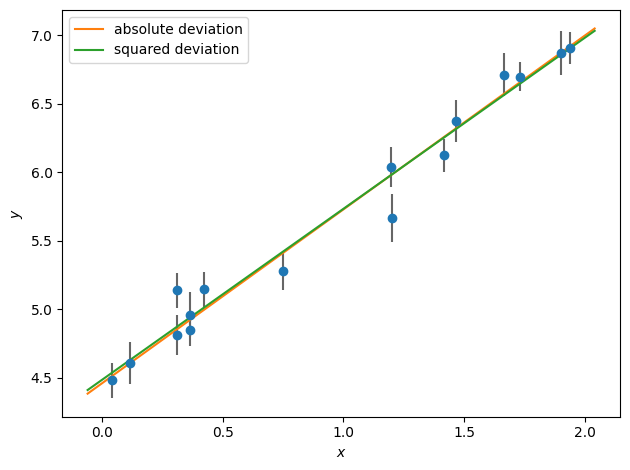

In [10]:
plt.errorbar(x, y, y_err, linestyle="none", marker="o", ecolor="#666666")

x_grid = np.linspace(x.min() - 0.1, x.max() + 0.1, 128)
plt.plot(
    x_grid,
    line_model(best_pars_abs, x_grid),
    marker="",
    linestyle="-",
    label="absolute deviation",
)
plt.plot(
    x_grid,
    line_model(best_pars_sq, x_grid),
    marker="",
    linestyle="-",
    label="squared deviation",
)

plt.xlabel("$x$")
plt.ylabel("$y$")

plt.legend(loc="best")
plt.tight_layout()

## Least-squares / maximum likelihood with matrix calculus

In [11]:
# create matrices and vectors:

# learn this is a magical function - it makes exactly what we want for the design matrix
X = np.vander(x, N=2, increasing=True)

# you never want to do this in practice because the matrix will just be full of zeros!
#   that's a good way to waste all of your RAM on storing zeros...
Cov = np.diag(y_err**2)
Cinv = np.linalg.inv(Cov)  # we need the inverse covariance matrix

X.shape, Cov.shape, y.shape

((16, 2), (16, 16), (16,))

In [13]:
# using the new Python matrix operator
best_pars_linalg = np.linalg.inv(X.T @ Cinv @ X) @ (X.T @ Cinv @ y)

# we can also get the parameter covariance matrix
pars_Cov = np.linalg.inv(X.T @ Cinv @ X)

In [15]:
best_pars_linalg

array([4.48345389, 1.25017893])

In [16]:
best_pars_sq - best_pars_linalg[::-1]

array([-3.9915542e-09, -3.1165408e-09])

In [17]:
pars_Cov

array([[ 0.00351308, -0.00244964],
       [-0.00244964,  0.00253369]])

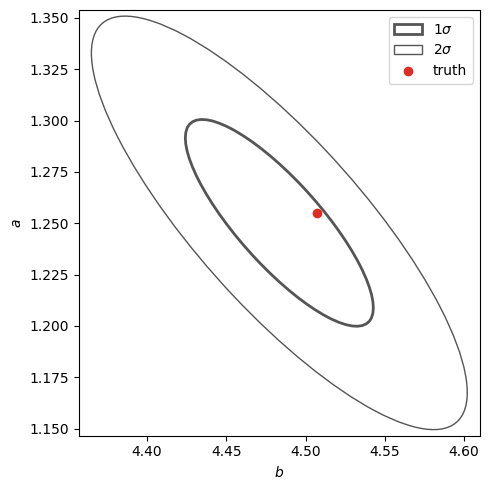

In [19]:
# some tricks to get info we need to plot an ellipse, aligned with
#    the eigenvectors of the covariance matrix
eigval, eigvec = np.linalg.eig(pars_Cov)
angle = np.degrees(np.arctan2(eigvec[1, 0], eigvec[0, 0]))
w, h = 2 * np.sqrt(eigval)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for n in [1, 2]:
    ax.add_patch(
        Ellipse(
            best_pars_linalg,
            width=n * w,
            height=n * h,
            angle=angle,
            fill=False,
            linewidth=3 - n,
            edgecolor="#555555",
            label=r"{}$\sigma$".format(n),
        )
    )

ax.plot(
    b_true,
    a_true,
    marker="o",
    zorder=10,
    linestyle="none",
    color="#de2d26",
    label="truth",
)

ax.set_xlabel("$b$")
ax.set_ylabel("$a$")
ax.legend(loc="best")

fig.tight_layout()

## The Bayesian approach

In [20]:
class StraightLineModel(object):
    def __init__(self, x, y, y_err):
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)

    def ln_likelihood(self, pars):
        """
        This is basically the same as the weighted squared
        deviation function, but includes the constant normalizations for the
        Gaussian likelihood.
        """
        N = len(self.y)
        dy = self.y - line_model(pars, self.x)
        ivar = 1 / self.y_err**2  # inverse-variance
        return -0.5 * (
            N * np.log(2 * np.pi)
            + np.sum(2 * np.log(self.y_err))
            + np.sum(dy**2 * ivar)
        )

    def ln_prior(self, pars):
        """
        The prior only depends on the parameters, so we don't need to touch
        the data at all. We're going to implement a flat (uniform) prior
        over the ranges:
            a : [0, 100]
            b : [-50, 50]

        """

        a, b = pars  # unpack parameters
        ln_prior_val = 0.0  # we'll add to this

        if a < 0 or a > 100.0:
            return -np.inf
        else:
            ln_prior_val += np.log(1e-2)  # normalization, log(1/100)

        if b < -50 or b > 50.0:
            return -np.inf
        else:
            ln_prior_val += np.log(1e-2)  # normalization, log(1/100)

        return ln_prior_val

    def ln_posterior(self, pars):
        """
        Up to a normalization constant, the log of the posterior pdf is just
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp):
            # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars)
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob

    def __call__(self, pars):
        return self.ln_posterior(pars)


def evaluate_on_grid(func, a_grid, b_grid, args=()):
    a_grid, b_grid = np.meshgrid(a_grid, b_grid)
    ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel())).T

    func_vals = np.zeros(ab_grid.shape[0])
    for j, pars in enumerate(ab_grid):
        func_vals[j] = func(pars, *args)

    return func_vals.reshape(a_grid.shape)


model = StraightLineModel(x, y, y_err)

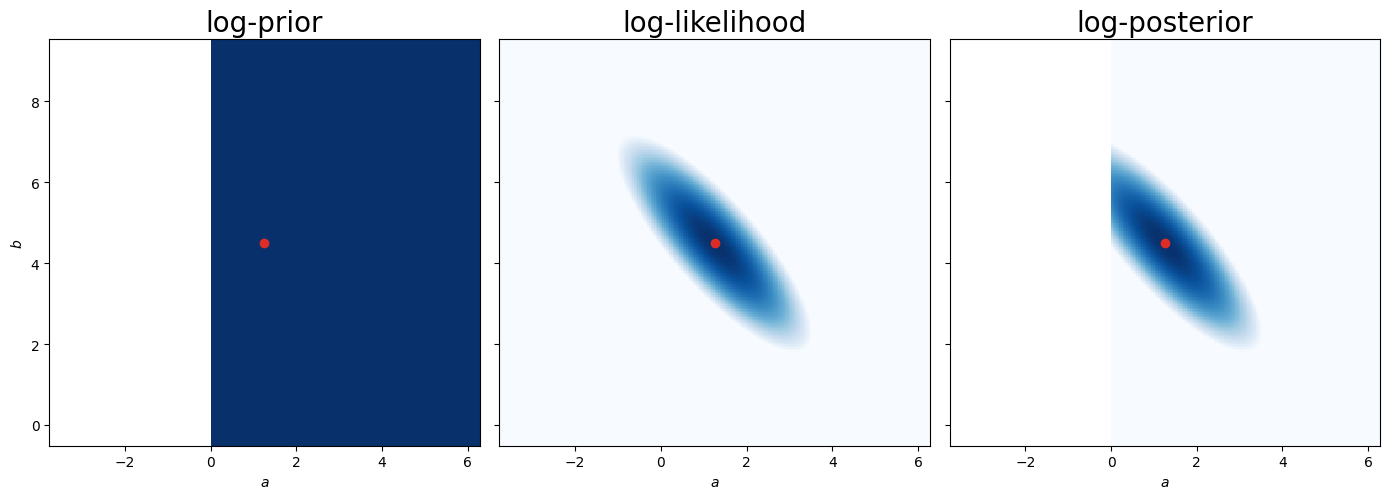

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5.1), sharex=True, sharey=True)

# make a 256x256 grid of parameter values centered on the true values
a_grid = np.linspace(a_true - 5.0, a_true + 5, 256)
b_grid = np.linspace(b_true - 5.0, b_true + 5, 256)

ln_prior_vals = evaluate_on_grid(model.ln_prior, a_grid, b_grid)
ln_like_vals = evaluate_on_grid(model.ln_likelihood, a_grid, b_grid)
ln_post_vals = evaluate_on_grid(model.ln_posterior, a_grid, b_grid)

for i, vals in enumerate([ln_prior_vals, ln_like_vals, ln_post_vals]):
    axes[i].pcolormesh(
        a_grid, b_grid, vals, cmap="Blues", vmin=vals.max() - 1024, vmax=vals.max()
    )  # arbitrary scale

axes[0].set_title("log-prior", fontsize=20)
axes[1].set_title("log-likelihood", fontsize=20)
axes[2].set_title("log-posterior", fontsize=20)

for ax in axes:
    ax.set_xlabel("$a$")

    # plot the truth
    ax.plot(a_true, b_true, marker="o", zorder=10, color="#de2d26")
    ax.axis("tight")

axes[0].set_ylabel("$b$")
fig.tight_layout()

In [22]:
class StraightLineModelGaussianPrior(StraightLineModel):
    def ln_prior(self, pars):
        a, b = pars  # unpack parameters
        ln_prior_val = 0.0  # we'll add to this

        # prior on a is a Gaussian with mean, stddev = (3, 0.05)
        ln_prior_val += (
            -0.5 * (a - 3.0) ** 2 / 0.05**2
        )  # this is not normalized properly, but that's ok

        # prior on b is a Gaussian with mean, stddev = (5.5, 0.05)
        ln_prior_val += (
            -0.5 * (b - 5.5) ** 2 / 0.05**2
        )  # this is not normalized properly, but that's ok

        return ln_prior_val


model_Gprior = StraightLineModelGaussianPrior(x, y, y_err)

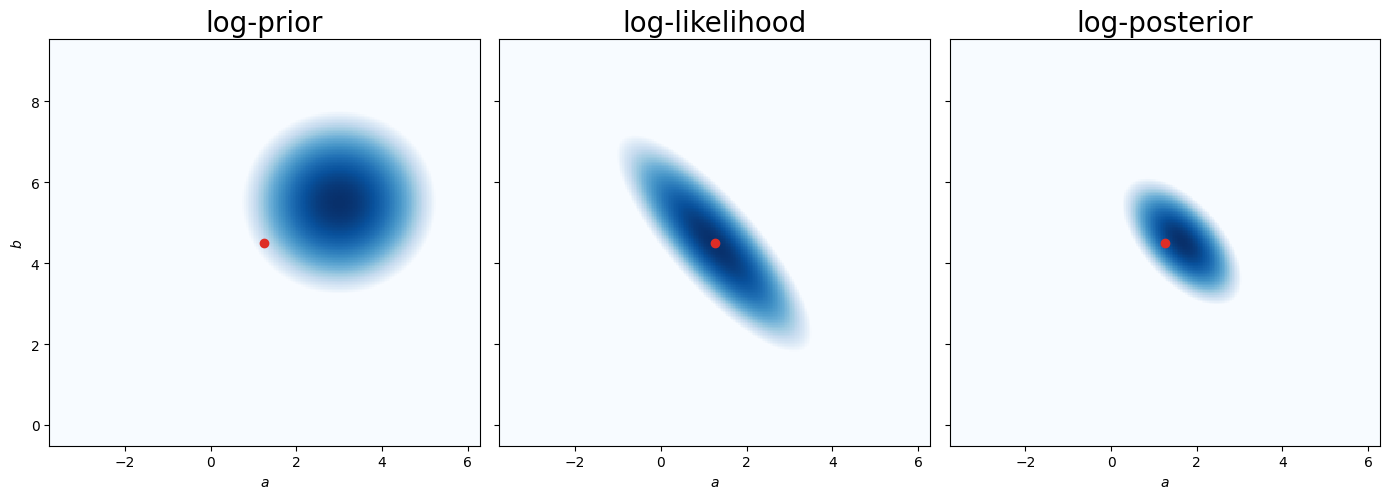

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5.1), sharex=True, sharey=True)

ln_prior_vals2 = evaluate_on_grid(model_Gprior.ln_prior, a_grid, b_grid)
ln_like_vals2 = evaluate_on_grid(model_Gprior.ln_likelihood, a_grid, b_grid)
ln_post_vals2 = evaluate_on_grid(model_Gprior.ln_posterior, a_grid, b_grid)

for i, vals in enumerate([ln_prior_vals2, ln_like_vals2, ln_post_vals2]):
    axes[i].pcolormesh(
        a_grid, b_grid, vals, cmap="Blues", vmin=vals.max() - 1024, vmax=vals.max()
    )  # arbitrary scale

axes[0].set_title("log-prior", fontsize=20)
axes[1].set_title("log-likelihood", fontsize=20)
axes[2].set_title("log-posterior", fontsize=20)

for ax in axes:
    ax.set_xlabel("$a$")

    # plot the truth
    ax.plot(a_true, b_true, marker="o", zorder=10, color="#de2d26")
    ax.axis("tight")

axes[0].set_ylabel("$b$")

fig.tight_layout()

In [24]:
def sample_proposal(*sigmas):
    return np.random.normal(0.0, sigmas)


def run_metropolis_hastings(p0, n_steps, model, proposal_sigmas):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.

    Parameters
    ----------
    p0 : iterable
        Initial parameter vector.
    n_steps : int
        Number of steps to run the sampler for.
    model : StraightLineModel instance (or subclass)
        A callable object that takes a parameter vector and computes
        the log of the posterior pdf.
    proposal_sigmas : list, array
        A list of standard-deviations passed to the sample_proposal
        function. These are like step sizes in each of the parameters.
    """
    p0 = np.array(p0)
    if len(proposal_sigmas) != len(p0):
        raise ValueError(
            "Proposal distribution should have same shape as parameter vector."
        )

    # the objects we'll fill and return:
    chain = np.zeros((n_steps, len(p0)))  # parameter values at each step
    ln_probs = np.zeros(n_steps)  # log-probability values at each step

    # we'll keep track of how many steps we accept to compute the acceptance fraction
    n_accept = 0

    # evaluate the log-posterior at the initial position and store starting position in chain
    ln_probs[0] = model(p0)
    chain[0] = p0

    # loop through the number of steps requested and run MCMC
    for i in range(1, n_steps):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i - 1] + step

        # compute log-posterior at new parameter values
        new_ln_prob = model(new_p)

        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i - 1]

        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1

        else:
            chain[i] = chain[i - 1]
            ln_probs[i] = ln_probs[i - 1]

    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac

In [25]:
model

In [26]:
p0 = [6.0, 6.0]
chain, _, acc_frac = run_metropolis_hastings(
    p0, n_steps=8192, model=model, proposal_sigmas=[0.05, 0.05]
)
print("Acceptance fraction: {:.1%}".format(acc_frac))

Acceptance fraction: 42.4%


Text(38.34722222222222, 0.5, '$b$')

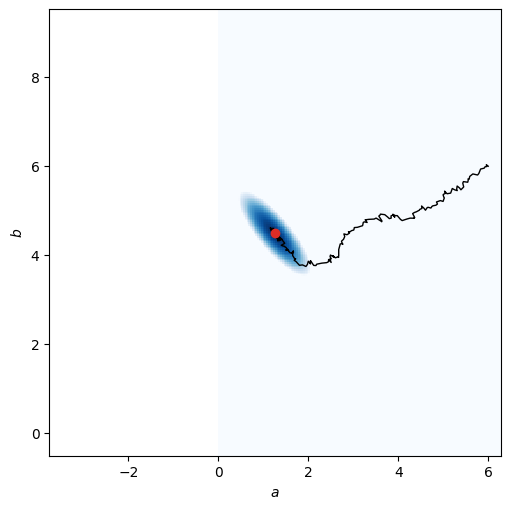

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.pcolormesh(
    a_grid,
    b_grid,
    ln_post_vals,
    cmap="Blues",
    vmin=ln_post_vals.max() - 128,
    vmax=ln_post_vals.max(),
)  # arbitrary scale
ax.axis("tight")

fig.tight_layout()

ax.plot(a_true, b_true, marker="o", zorder=10, color="#de2d26")
ax.plot(chain[:512, 0], chain[:512, 1], marker="", color="k", linewidth=1.0)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")

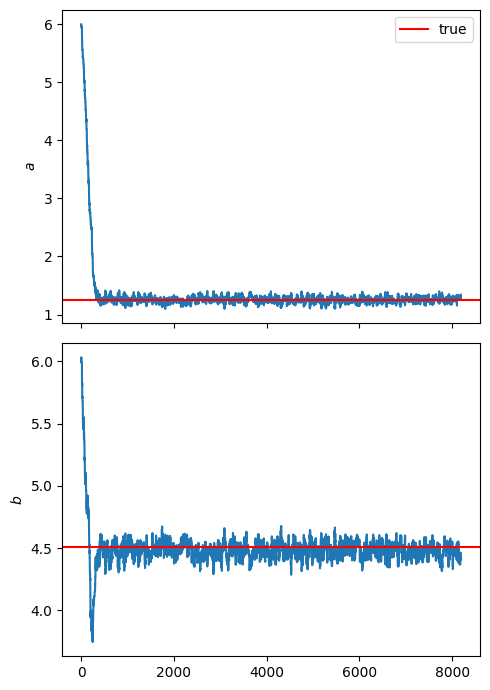

In [28]:
fig, axes = plt.subplots(len(p0), 1, figsize=(5, 7), sharex=True)

for i in range(len(p0)):
    axes[i].plot(chain[:, i], marker="", drawstyle="steps")

axes[0].axhline(a_true, color="r", label="true")
axes[0].legend(loc="best")
axes[0].set_ylabel("$a$")

axes[1].axhline(b_true, color="r")
axes[1].set_ylabel("$b$")

fig.tight_layout()

In [29]:
good_samples = chain[2000::8]
good_samples.shape

(774, 2)

In [30]:
low, med, hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi - med, med - low

disp_str = ""
for i, name in enumerate(["a", "b"]):
    fmt_str = "{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}"
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r"\quad "

disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

In [31]:
a_true, b_true

(1.255, 4.507)

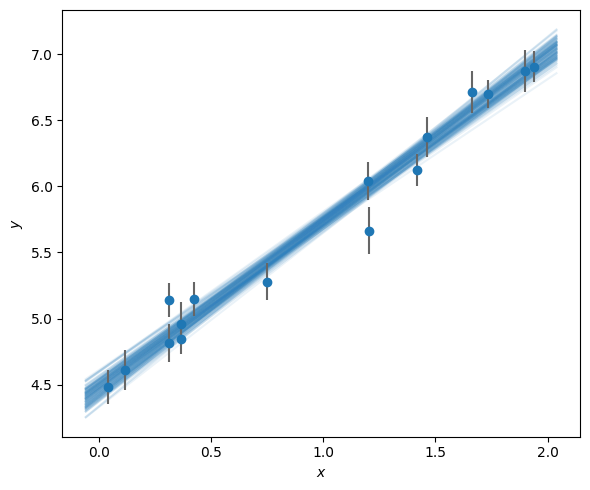

In [32]:
plt.figure(figsize=(6, 5))
plt.errorbar(x, y, y_err, linestyle="none", marker="o", ecolor="#666666")

x_grid = np.linspace(x.min() - 0.1, x.max() + 0.1, 128)
for pars in good_samples[:128]:  # only plot 128 samples
    plt.plot(
        x_grid,
        line_model(pars, x_grid),
        marker="",
        linestyle="-",
        color="#3182bd",
        alpha=0.1,
        zorder=-10,
    )

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()

In [34]:
import corner

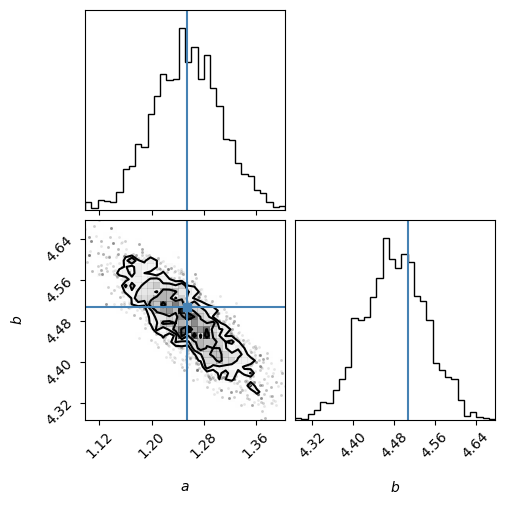

In [35]:
fig = corner.corner(
    chain[2000:], bins=32, labels=["$a$", "$b$"], truths=[a_true, b_true]
)

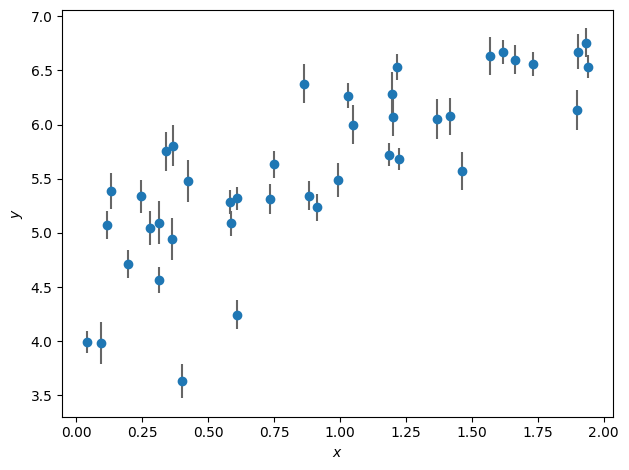

In [36]:
V_true = 0.5**2
n_data = 42

# we'll keep the same parameters for the line as we used above

x = rnd.uniform(0, 2.0, n_data)
x.sort()  # sort the values in place

y = a_true * x + b_true

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = rnd.uniform(
    0.1, 0.2, size=n_data
)  # randomly generate uncertainty for each datum

# add Gaussian intrinsic width
y = rnd.normal(
    y, np.sqrt(y_err**2 + V_true)
)  # re-sample y data with noise and intrinsic scatter

plt.errorbar(x, y, y_err, linestyle="none", marker="o", ecolor="#666666")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()


In [37]:
X = np.vander(x, N=2, increasing=True)
Cov = np.diag(y_err**2)
Cinv = np.linalg.inv(Cov)

best_pars = np.linalg.inv(X.T @ Cinv @ X) @ (X.T @ Cinv @ y)
pars_Cov = np.linalg.inv(X.T @ Cinv @ X)
best_pars, pars_Cov

(array([4.5170343 , 1.16209418]),
 array([[ 0.00160262, -0.00124365],
        [-0.00124365,  0.00134739]]))

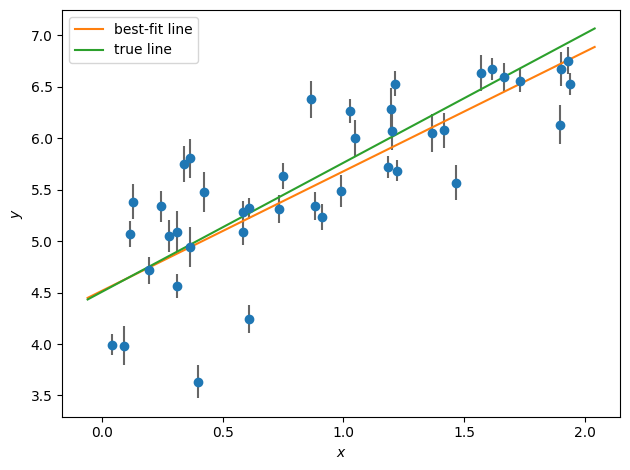

In [38]:
plt.errorbar(x, y, y_err, linestyle="none", marker="o", ecolor="#666666")

x_grid = np.linspace(x.min() - 0.1, x.max() + 0.1, 128)
plt.plot(
    x_grid,
    line_model(best_pars[::-1], x_grid),
    marker="",
    linestyle="-",
    label="best-fit line",
)
plt.plot(
    x_grid,
    line_model([a_true, b_true], x_grid),
    marker="",
    linestyle="-",
    label="true line",
)

plt.xlabel("$x$")
plt.ylabel("$y$")

plt.legend(loc="best")
plt.tight_layout()

In [39]:
class StraightLineIntrinsicScatterModel(StraightLineModel):
    def ln_prior(self, pars):
        """The prior only depends on the parameters"""

        a, b, lnV = pars

        # flat priors on a, b, lnV
        if a < -10 or a > 10 or b < -100.0 or b > 100.0 or lnV < -10.0 or lnV > 10.0:
            return -np.inf

        # this is only valid up to a numerical constant
        return 0.0

    def ln_likelihood(self, pars):
        """The likelihood function evaluation requires a particular set of model parameters and the data"""
        a, b, lnV = pars
        V = np.exp(lnV)

        N = len(y)
        dy = y - line_model([a, b], self.x)
        ivar = 1 / (
            self.y_err**2 + V
        )  # inverse-variance now includes intrinsic scatter
        return -0.5 * (
            N * np.log(2 * np.pi) - np.sum(np.log(ivar)) + np.sum(dy**2 * ivar)
        )


scatter_model = StraightLineIntrinsicScatterModel(x, y, y_err)

In [40]:
x0 = [5.0, 5.0, 0.0]  # starting guess for the optimizer

# we have to minimize the negative log-likelihood to maximize the likelihood
result_ml_scatter = minimize(
    lambda *args: -scatter_model.ln_likelihood(*args), x0=x0, method="BFGS"
)
result_ml_scatter

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 27.609011123486415
        x: [ 1.096e+00  4.606e+00 -1.646e+00]
      nit: 19
      jac: [ 0.000e+00  0.000e+00 -2.384e-07]
 hess_inv: [[ 1.517e-02 -1.351e-02 -6.104e-04]
            [-1.351e-02  1.703e-02  1.156e-03]
            [-6.104e-04  1.156e-03  6.063e-02]]
     nfev: 112
     njev: 28

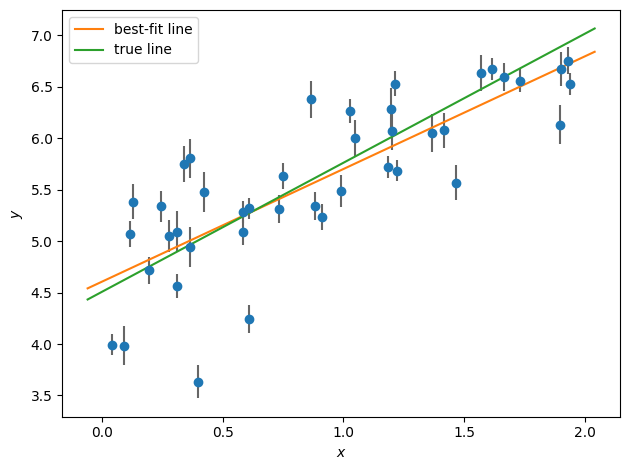

In [41]:
plt.errorbar(x, y, y_err, linestyle="none", marker="o", ecolor="#666666")

x_grid = np.linspace(x.min() - 0.1, x.max() + 0.1, 128)
plt.plot(
    x_grid,
    line_model(result_ml_scatter.x[:2], x_grid),
    marker="",
    linestyle="-",
    label="best-fit line",
)
plt.plot(
    x_grid,
    line_model([a_true, b_true], x_grid),
    marker="",
    linestyle="-",
    label="true line",
)

plt.xlabel("$x$")
plt.ylabel("$y$")

plt.legend(loc="best")
plt.tight_layout()

In [42]:
V_true, np.exp(result_ml_scatter.x[2])

(0.25, 0.19289760718803528)

In [43]:
p0 = [6.0, 6.0, -1.0]
chain, _, acc_frac = run_metropolis_hastings(
    p0, n_steps=2**16, model=scatter_model, proposal_sigmas=[0.15, 0.15, 0.2]
)
acc_frac

0.288299560546875

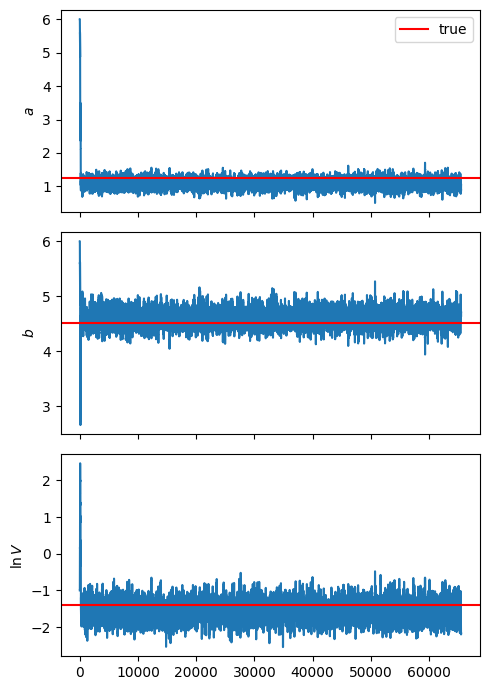

In [44]:
fig, axes = plt.subplots(len(p0), 1, figsize=(5, 7), sharex=True)

for i in range(len(p0)):
    axes[i].plot(chain[:, i], marker="", drawstyle="steps")

axes[0].axhline(a_true, color="r", label="true")
axes[0].legend(loc="best")
axes[0].set_ylabel("$a$")

axes[1].axhline(b_true, color="r")
axes[1].set_ylabel("$b$")

axes[2].axhline(np.log(V_true), color="r")
axes[2].set_ylabel(r"$\ln V$")

fig.tight_layout()

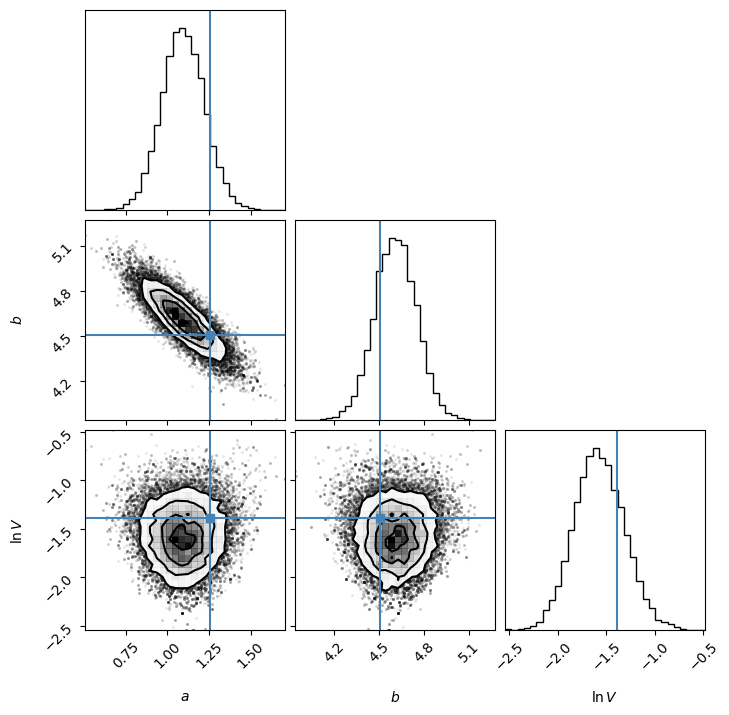

In [45]:
fig = corner.corner(
    chain[2000:],
    bins=32,
    labels=["$a$", "$b$", r"$\ln V$"],
    truths=[a_true, b_true, np.log(V_true)],
)

In [46]:
good_samples = chain[2000::8]
good_samples.shape

(7942, 3)

In [47]:
low, med, hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi - med, med - low

disp_str = ""
for i, name in enumerate(["a", "b", r"\ln V"]):
    fmt_str = "{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}"
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r"\quad "

disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

In [48]:
disp_str = ""
for i, name in zip([1, 0], ["a", "b"]):
    fmt_str = r"{name}={val:.2f} \pm {err:.2f}"
    disp_str += fmt_str.format(name=name, val=best_pars[i], err=np.sqrt(pars_Cov[i, i]))
    disp_str += r"\quad "

disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

In [49]:
a_true, b_true

(1.255, 4.507)